In [1]:
import lyrics_scraper 
import os
import time
import datetime
import nltk

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random



import torch
#from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import Trainer, TrainingArguments, logging
from transformers import AdamW, get_linear_schedule_with_warmup
from datasets import Dataset 

141


<AxesSubplot:ylabel='Count'>

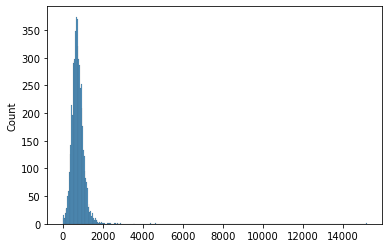

In [4]:


data = lyrics_scraper.retrieve_lyrics()
lyrics = data.lyrics_col.copy()
song_lengths = []

# HuggingFace Datasets class lets us load in and pre-process data 
dataset = Dataset.from_pandas(data)

# 80% train, 20% validation, split done using HuggingFace's Dataset train_test_split which is adapted from sci-kit learn's famous train_test split method
train_testvalid = dataset.train_test_split(test_size=0.2)

for song in lyrics:
    tokens = nltk.word_tokenize(song)
    song_lengths.append(len(tokens))

song_lengths = np.array(song_lengths)

sns.histplot(song_lengths)

In [5]:
# Percentage of songs with tokenized length longer than the input size of GPT2-medium which is 1024
len(song_lengths[song_lengths > 1024])/len(song_lengths)

0.14509169363538296

In [6]:
# On average how many tokens 
np.average(song_lengths)

758.6929162171881

In [7]:
# To tokenize all our texts with the same vocabulary that was used when training the model, we have to download a pretrained tokenizer. This is all done by the AutoTokenizer class:
tokenizer = AutoTokenizer.from_pretrained('gpt2', pad_token='<|pad|>') #gpt2

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [8]:
# We can now call the tokenizer on all our texts. This is very simple, using the map method from the Datasets library. First we define a function that call the tokenizer on our texts:
def tokenize_function(data):
    return tokenizer(data["lyrics_col"], truncation=True)

In [9]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
#print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|endoftext|> token has the id 50256
The end of sequence token <|endoftext|> has the id 50256


In [10]:
tokenized_datasets = train_testvalid.map(tokenize_function, batched=True, remove_columns=["lyrics_col"])

100%|██████████| 2/2 [00:00<00:00,  4.10ba/s]


In [11]:
block_size = 768

In [12]:
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [13]:
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True
)


100%|██████████| 2/2 [00:05<00:00,  2.68s/ba]


In [14]:
# And we can check our datasets have changed: now the samples contain chunks of block_size contiguous tokens, potentially spanning over several of our original texts.
print (tokenizer.decode(lm_datasets["train"][0]["input_ids"]))
print (len(lm_datasets['train']))
print (len(lm_datasets['test']))


<< Wiz Khalifa - Phone Numbers >> 

[Intro: Wiz Khalifa]
Listen to this track, bitch
Yeah, usually I be smoking weed on the intro
But, I'm drinking water
This Cabin Fever, sick
I'm not gonna tell you again, stay the hell away from my woman
Taylor Gang, niggas think you can do whatever you want
Uh

[Verse 1: Wiz Khalifa]
I cop me one, cop me one for my old girl
You think she my newest bitch, she my old girl
Khalifa, a younger nigga who handle his
Hoes get in my car ask what the channel is
Boss shit, look that up my nigga, I handle biz
On fire, like a candle is
Niggas be dressing off the mannequin
Mmm, and I get fresh like where them cameras is
Better yet sandwiches, bad bitch Spanish friends
Coulda been the President rather be the man instead, yeah

[Chorus: Wiz Khalifa]
Now when I get paid my checks be lookin' like phone numbers
Now when I get paid my checks be lookin' like phone numbers
(You can talk shit bitch, I'm worth a million)
I'm talking millions, nigga I'm talking millions
(Y

In [15]:

# instantiate the model
model = AutoModelForCausalLM.from_pretrained()

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Empty cache
torch.cuda.empty_cache()

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
#seed_val = 42

#random.seed(seed_val)
#np.random.seed(seed_val)
#torch.manual_seed(seed_val)
#torch.cuda.manual_seed_all(seed_val)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

In [16]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_eval_batch_size=1,
    per_device_train_batch_size=1,
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_steps=100,
    logging_dir='./logs',
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["test"]
)

In [17]:
logging.set_verbosity_info()

In [18]:
# Empty cache

torch.cuda.empty_cache()
trainer.train()

Loading model from results/checkpoint-10208).
loading configuration file results/checkpoint-10208\config.json
Model config GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "gradient_checkpointing": false,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.4.2",
  "use_cache": true,
  "vocab_size": 50258
}

loading weights file results/checkpoint-10208\pytorch_model.bi

TrainOutput(global_step=15348, training_loss=0.9330794846666708, metrics={'train_runtime': 1190.9081, 'train_samples_per_second': 12.888, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 57194, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18258, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 1594379, 'train_mem_gpu_alloc_delta': 2518516224, 'train_mem_cpu_peaked_delta': 154959683, 'train_mem_gpu_peaked_delta': 2059400192})

In [19]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

NameError: name 'training_stats' is not defined

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [20]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50258, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [21]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save_NEW/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Configuration saved in ./model_save_NEW/config.json
Saving model to ./model_save_NEW/
Model weights saved in ./model_save_NEW/pytorch_model.bin
tokenizer config file saved in ./model_save_NEW/tokenizer_config.json
Special tokens file saved in ./model_save_NEW/special_tokens_map.json


('./model_save_NEW/tokenizer_config.json',
 './model_save_NEW/special_tokens_map.json',
 './model_save_NEW/vocab.json',
 './model_save_NEW/merges.txt',
 './model_save_NEW/added_tokens.json')

In [19]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer


# # Load a trained model and vocabulary that you have fine-tuned
output_dir = './model_save_headers/'

#empty cache
torch.cuda.empty_cache()

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")

model = GPT2LMHeadModel.from_pretrained(output_dir)

model.cuda()

tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

In [21]:
model.eval()

prompt = """
<|startoftext|>
[Verse 1]
"""



generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,    
                                max_length = 500, 
                                top_p=0.92,
                                num_return_sequences=25
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
tensor([[  198, 50257,   198,    58, 13414,   325,   352,    60,   198]],
       device='cuda:0')
0: 

[Verse 1]
Now you're all I can see
Came from the bottom and now your family depend on me
So now you're all I can see
Can't nobody do it like you do
And if you wanna live your life like you're supposed to
That's just something that I've been thinking about
It's just something I've been thinking about
And if you're gonna feel like the one I want to be, then it's a reason
So when I hear the sounds you make
You hear them chumps think it's just some homies talking
And I'm a lot of things, just trying to make a difference
But, I can't change on you, and I still can't get away
And you can hate what I say but you can't change on me
And I still don't give a fuck about you, about you
Cause I don't like what I see and I don't get caught up with you
I've got no friends, so now you're all I can see
Can't nobody do it like you 